---
format: 
  html:
    toc: true
execute:
  echo: true
---

# Worst Places to Live in Kathmandu

Despite Kathmandu's natural and historic beauty, the city in recent years has seen a rapid decline in living conditions. Haphazard sprawl, mismanaged public transport, rapid loss of green space, and climate change have been affecting the liveability of the city [1](https://fukuoka.unhabitat.org/wp-content/uploads/2021/12/Kathmandu_ValleyNepalMarch2015.pdf). While everyone acknowledges this problem, there is still a lack of quantified research into this topic, especially from an urban planning perspective. This is an issue for the city that contains 24% of the country's urban population, and contributes to 33% of the country's GDP [2](https://www.kvda.gov.np/uploads/form/SDMP%20part1.pdf). With agricultural and forested land increasingly being decimated to accomodate this sprawl, the valley is facing an environmental crisis that routinely puts it as the most polluted city in the world [3](https://kathmandupost.com/climate-environment/2024/04/10/kathmandu-world-s-most-polluted-city-again).

I seek to examine these trends, especially as they relate to loss of greenery and urban heat islands in this section of the report. Using satellite data from Landsat 8, I seek to calculate the NDVI (Normalized Difference Vegetation Index), a measure for greenergy, as well as the Land Surface Temperature (LST), a measure for temperature, for the city between the years 2013 and 2023. Using the insights gathered from this extraction, I seek to identify the regions of the city that perform worse on these indexes. Combining the output from my raster data to the census data in part 1, I seek to put forth a novel, intersectional analysis of sprawl, wealth and environmental degredation in the city.

## Getting Landsat Data with Earth Engine

To begin my analysis, I first download and extract my required files from the Google Earth Engine API. I will first call an earth engine object that contains composite, cloud cover minimized values for the years 2013 and 2023. Then, using the valley and city boundaries extracted in part 1 of my analysis, I will limit these shapefiles to the boundaries of my study_area and perform the analysis.

In [1]:
#setting up GEE
import ee
ee.Authenticate()
ee.Initialize()

In [2]:
import geopandas as gpd
#calling valley geometry 
valley = gpd.read_file("../data/sfs/valley.geojson")
#creating an earth engine object of the boundary 
ee_geometry = ee.Geometry(valley.__geo_interface__['features'][0]['geometry'])

I have already created my composite, saved it to my google drive, and downloaded it locally on my repository. The code section below details my approach. For my analysis, I will begin by calling in my locally saved files in the next section.

In [100]:
# setting up my start and end dates for two years
start_date_2013 = '2013-01-01'
start_date_2023 = '2023-01-01'
end_date_2013 = '2013-12-31'
end_date_2023 = '2023-12-31'

#creating yearly composite
comp_2013 =  ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterBounds(ee_geometry).filterDate(start_date_2013, end_date_2013).filter(ee.Filter.lt('CLOUD_COVER', 20)).median()
comp_2023 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')\
    .filterBounds(ee_geometry)\
    .filterDate(start_date_2023, end_date_2023)\
    .filter(ee.Filter.lt('CLOUD_COVER', 20))\
    .median()



#Creating tasks to extract it from Earth engine to my local google drive
task_2013 = ee.batch.Export.image.toDrive(
    image=comp_2013,
    description='landsat_13',
    scale=30, 
    region=ee_geometry,
    maxPixels=1e9,
    fileFormat='GeoTIFF'
)

# Export 2023 composite
task_2023 = ee.batch.Export.image.toDrive(
    image=comp_2023,
    description='landsat_23',
    scale=30,
    region=ee_geometry,
    maxPixels=1e9,
    fileFormat='GeoTIFF'
)

#starting tasks
task_2013.start()
task_2023.start()

## Calculating NDVI and LST
I have the data already loaded to my local system, so I will start by loading it in. I will also mask my rasters to the extent of my study area. After loading the data, two key environmental measures will be extracted—NDVI, which measures the amount of greenery, and LST values of the extent. 

NDVI is calculated using Landsat's Near-Infrared (Band 5) and Red (Band 4) bands, following the formula: NDVI = (NIR - Red)/(NIR + Red), where NIR is Band 5 and Red is Band 4. This index ranges from -1 to 1, with higher values indicating denser vegetation. 

In [94]:
import rasterio as rio
from shapely.geometry import box
from rasterio.mask import mask
import numpy as np

#calling my rasters
landsat13 = rio.open("../data/landsat/landsat_13.tif")
landsat23 = rio.open("../data/landsat/landsat_23.tif")

#calling my city file
main_city = gpd.read_file('../data/sfs/maincity.geojson')


study_masked13, study_transform13 = mask(
    dataset=landsat13,              
    shapes=main_city.geometry,  
    crop=True,                    
    all_touched=True,            
    filled=False,                 
)

study_masked23, study_transform23 = mask(
    dataset=landsat23,              
    shapes=main_city.geometry,  
    crop=True,                    
    all_touched=True,            
    filled=False,                 
)

#getting the needed layers
red13 = study_masked13[4]
nir13 = study_masked13[5]
red23 = study_masked23[4]
nir23= study_masked23[5]

#calculating NDVI
def calculate_NDVI(nir, red):
    """
    Calculate the NDVI from the NIR and red landsat bands
    """

    # Convert to floats
    nir = nir.astype(float)
    red = red.astype(float)

    # Get valid entries
    check = np.logical_and(red.mask == False, nir.mask == False)

    # Where the check is True, return the NDVI, else return NaN
    ndvi = np.where(check, (nir - red) / (nir + red), np.nan)
    
    # Return
    return ndvi

NDVI13 = calculate_NDVI(nir13, red13)
NDVI23 = calculate_NDVI(nir23, red23)


LST can be calculated using Landsat's Thermal Infrared (Band 10) data through a multi-step process: first converting the digital numbers to top-of-atmosphere radiance, then to brightness temperature, and finally applying emissivity corrections to obtain land surface temperature in Kelvin or Celsius. The LST calculations requires a bit of physics that is beyond me, but I got the steps from this [article](https://iopscience.iop.org/article/10.1088/1757-899X/811/1/012045/pdf).

In [201]:
therm13 = study_masked13[10].astype(float)
therm23 = study_masked23[10].astype(float)

def calculate_lst(thermal, ndvi_data):
    """Calculate Land Surface Temperature using thermal and NDVI data"""
    # Constants
    k1 = 774.8853  # First thermal constant for Landsat 8 Band 10
    k2 = 1321.0789 # Second thermal constant for Landsat 8 Band 10
    
    radiance = thermal * 0.00341802 + 149
    
    # Check valid (unmasked) pixels
    check = np.logical_and(~np.isnan(radiance), ~np.isnan(ndvi_data))

    bt = k2 / (np.log((k1 / radiance) + 1))
    
    ndvi_min = np.nanmin(ndvi_data[~np.isnan(ndvi_data)])  
    ndvi_max = np.nanmax(ndvi_data[~np.isnan(ndvi_data)])  
    
    p_array = np.where(check, 
                      ((ndvi_data - ndvi_min)/(ndvi_max - ndvi_min))**2,
                      np.nan)
    
    emissivity = 0.004 * p_array + 0.986
    
    lst = bt/(1 + (0.00115 * bt/1.4388) * np.log(emissivity))
    
    return lst - 273.5

lst13sad = calculate_lst(therm13, NDVI13)

However, no matter how hard I tried, I couldn't get this data to work out for me. It kept giving me wrong values and after a time, I decided to call my losses and skip this section. If I had more time then I would do the LST calcualtions as well.

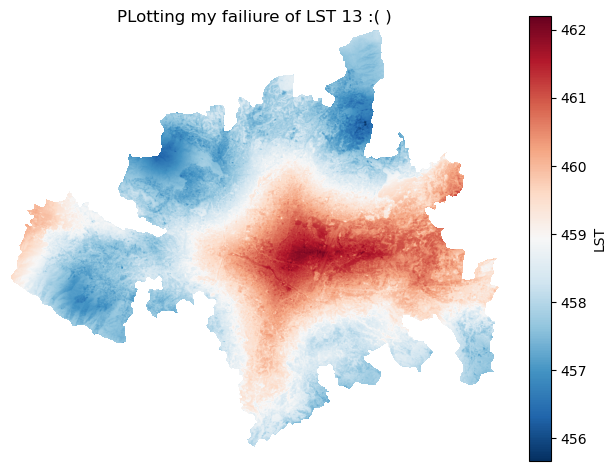

In [202]:
import matplotlib.pyplot as plt
im = plt.imshow(lst13sad, cmap='RdBu_r')
plt.title('PLotting my failiure of LST 13 :( )')

cbar = plt.colorbar(im)
cbar.set_label('LST')

# Hide axes for cleaner look
plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

### Plotting NDVI

First, let us plot the greenery in the valley in 2013 and 2024. NDVI assigns a normalized value between -1 to 1 depending on the availability of vegetation in an area.

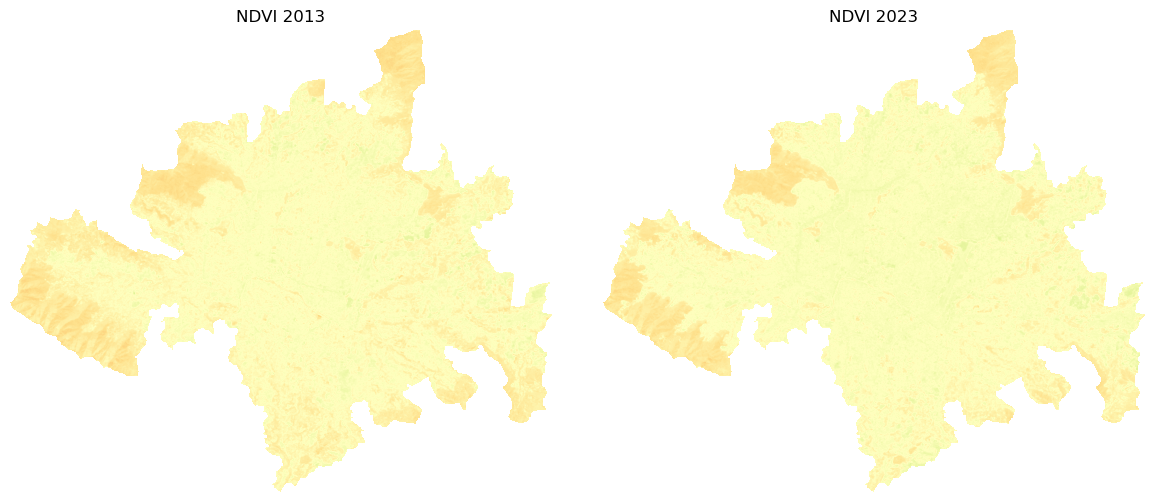

In [221]:
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 2008 NDVI
im1 = ax1.imshow(NDVI13, cmap='RdYlGn', vmin=-1, vmax=1)
ax1.set_title('NDVI 2013')
ax1.axis('off')  # Hide axes for cleaner look

# Plot 2023 NDVI
im2 = ax2.imshow(NDVI23, cmap='RdYlGn', vmin=-1, vmax=1)
ax2.set_title('NDVI 2023')
ax2.axis('off')  # Hide axes for cleaner look

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

We can see the difference between the two decades and find the areas which has experienced most loss of greenery.

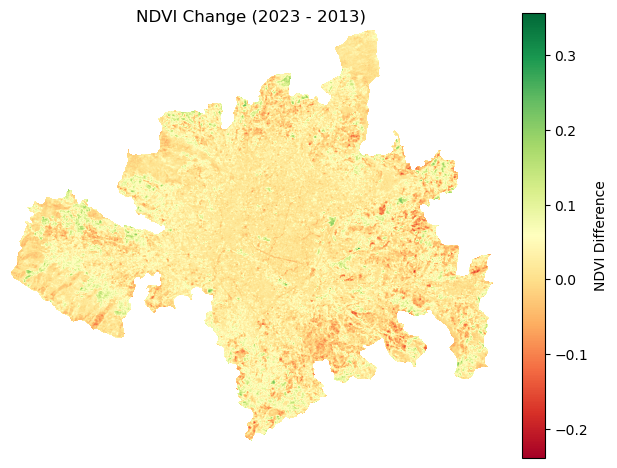

In [222]:
NDVI_diff = NDVI23 - NDVI13

im = plt.imshow(NDVI_diff, cmap='RdYlGn')
plt.title('NDVI Change (2023 - 2013)')

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('NDVI Difference')

# Hide axes for cleaner look
plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

Lets see how that transforms to ward data.

In [223]:
from rasterstats import zonal_stats

NDVI_diff= np.where(np.isnan(NDVI_diff), -9999, NDVI_diff)
stats = zonal_stats(
    main_city,  
    NDVI_diff,
    affine=landsat23.transform,  
    stats=['min', 'max', 'mean', 'median', 'majority'],
    nodata=-9999,
)

mean_stats = [stats_dict["mean"] for stats_dict in stats]
main_city["Avg NDVI Change"] = mean_stats


<Figure size 1000x1000 with 0 Axes>

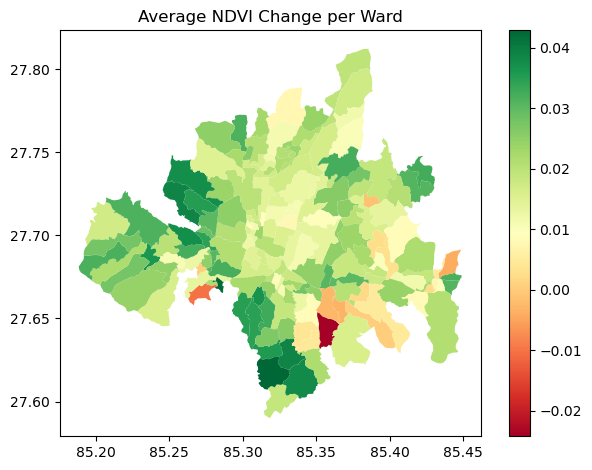

In [224]:
plt.figure(figsize=(10, 10))
main_city.plot(column='Avg NDVI Change', cmap='RdYlGn', legend=True)
plt.title('Average NDVI Change per Ward')
plt.tight_layout()
plt.show()